# Modèle SIR

#### Groupe : 
- Anna van Elst 
- Vincent Papegay-Vallet 



## Modèle deterministe

Description des variables :
- `N + 1` Population totale
- `S` Nombre de susceptibles
- `I` Nombre d'infectieux
- `R` Nombre de retirés 
- `etat` Tableau de taille 3 contenant les valeurs de `S, I, R`

In [33]:
from random import expovariate
import numpy as np
from scipy.integrate import odeint
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [34]:
# Fonction d'évolution
def evolution(etat, t, beta, gamma):
    S, I, _ = etat
    dS = - beta * I * S
    dI = beta * S * I  - gamma * I
    dR = gamma * I
    evo = np.array([dS, dI, dR])
    return(evo)

In [35]:
def epidemio_deterministe(beta, gamma, N=100000,duree=40):
    # Conditions initiales (S, I, R)
    y_0 = np.array([(N - 1) / N, 1 / N, 0])
    t = np.linspace(0, duree, N)
    # Calcul des courbes à l'aide de la fonction odeint
    result = odeint(evolution, y_0, t, args=(beta, gamma))
    return result, t, beta, gamma

In [36]:
def afficher_resultats(results, asymptote=True):
        plt.figure(figsize=(16,10))
        results, t, beta, gamma = results
        S = results[:,0]
        I = results[:, 1]
        R = results[:, 2]
        plt.plot(t, S, color='orange', label='Susceptible')
        plt.plot(t, I, color='red', label='Infectés')
        plt.plot(t, R, color='green', label='Retirés')
        plt.xlabel("Temps écoulé (j)")
        plt.ylabel("Proportion d'individus")
        plt.title(fr"Modélisation SIR deterministe $\beta = {beta}$ et $\gamma = {gamma}$", fontsize=15)
        # Calcul et affichage du R infini 
        if asymptote:
                r0 = beta / gamma
                lim = (1 + 1 / r0 * lambertw(-r0 * np.exp(-r0))) 
                plt.plot(t, np.array([lim for i in range(len(t))]), color='black', label=r'$r_{\infty}$')

        plt.legend(fontsize=15)
        plt.show()       

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


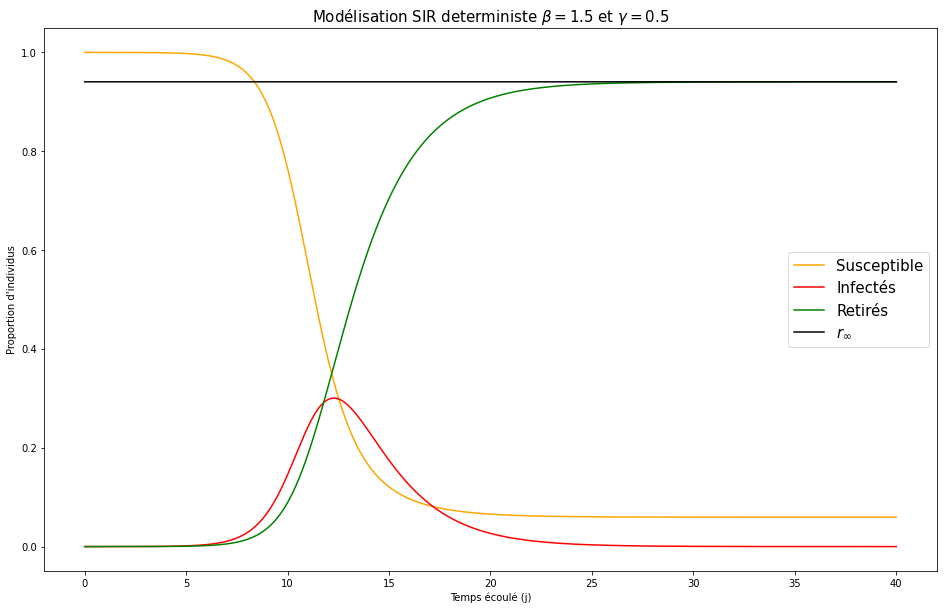

In [37]:
afficher_resultats(epidemio_deterministe(1.5, 0.5))

## Modèle Markovien

In [38]:
# Etape du processus de markov 
def evolution_markov(beta, gamma, etat, N):
    # On tire le premier evenement entre une infection et le fait de retirer un individu 
    # On effectue une disjonction de cas pour ne pas gérer les problèmes dùs au temps tirés infinis
    S, I, R = etat
    if (S > 0 and I > 0):
        t1 = expovariate(beta / N * I * S)
        t2 = expovariate(gamma * I)
        if t1 < t2:
            # Mise à jour des effectifs
            S -= 1
            I += 1
            t = t1
        else :
            # Mise à jour des effectifs
            I -= 1
            R += 1
            t = t2
    elif (S > 0):
        # Mise à jour des effectifs
        t = expovariate(beta / N * I * S)
        S -= 1
        I += 1
    else:
        # Mise à jour des effectifs
        t = expovariate(gamma * I)
        I -= 1
        R += 1
    return S, I, R, t

In [39]:
def processus_markov(beta, gamma, N=100000):
    T = [0]
    S, I, R = np.array([N - 1, 1, 0])
    St = [S]
    It = [I]
    Rt = [R]
    # Tour de processus de Markov tant qu'il reste des infectés 
    while (I > 0):
        S, I, R, t = evolution_markov(beta, gamma, np.array([S, I, R]), N)
        St.append(S)
        It.append(I)
        Rt.append(R)
        T.append(T[-1] + t)
    return (St, It, Rt, T, beta, gamma)

In [40]:
def afficher_markov(results, N=100000, comparaison=False):
    plt.figure(figsize=(16,10))
    St, It, Rt, T, beta, gamma = results
    if comparaison:
        plt.plot(T, St, color='orange', linestyle='-.', label='Susceptible')
        plt.plot(T, It, color='red', linestyle='-.', label='Infectés')
        plt.plot(T, Rt, color='green', linestyle='-.', label='Retirés')
    else:
        plt.plot(T, St, color='orange', label='Susceptible')
        plt.plot(T, It, color='red', label='Infectés')
        plt.plot(T, Rt, color='green', label='Retirés')
    plt.xlabel("Temps écoulé (j)")
    plt.ylabel("Proportion d'individus")
    print(f'Susceptibles restant : {St[-1]}')
    print(f'Infectés restant : {It[-1]}')
    print(f'Retirés : {Rt[-1]}')
    plt.legend(fontsize=15)
    plt.title(fr"Modélisation SIR par processus de Markov $\beta = {beta}$ et $\gamma = {gamma}$", fontsize=15)
    plt.show()
        

Le processus de Markov décrivant l'épidémie prend en compte la possibilité que le 1er infecté soit retiré avant d'infecter une autre personne. Il est donc possible qu'au bout d'un ou quelques tours seulement la propagation s'arrête. C'est pourquoi nous prenons un $R_0$ assez élevé dans la simulation suivante. Cependant il est tout de même possible que cela se produise, et pour visualiser une courbe intéressante il faut alors rlancer la simulation dans la cellule suivante. 

Susceptibles restant : 99999
Infectés restant : 0
Retirés : 1


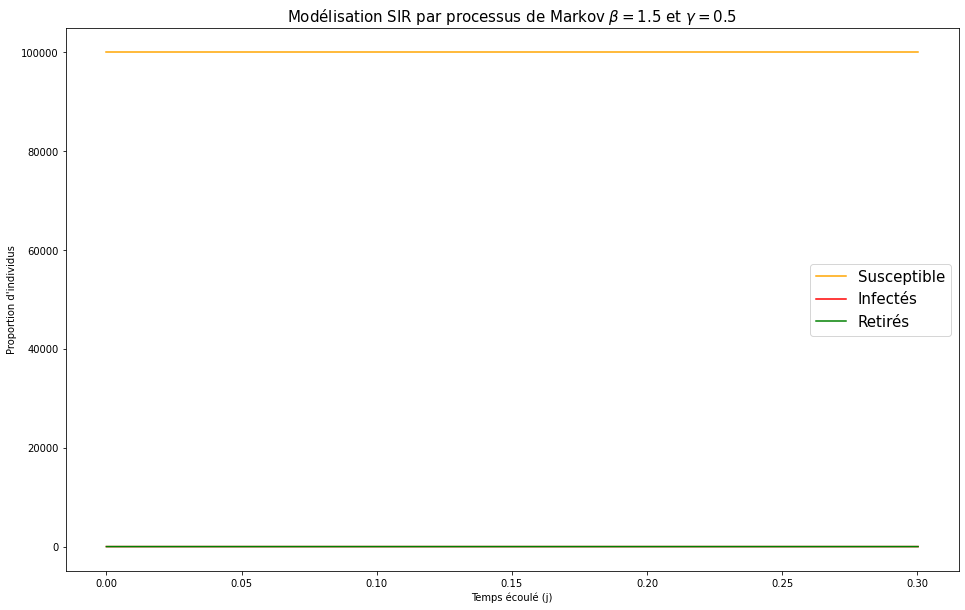

In [41]:
afficher_markov(processus_markov(1.5, 0.5))

## Identification des couples de valeurs $\beta$ et $\gamma$

On cherche à identifier un couple de valeurs $(\beta, \gamma)$ tel que tout le monde soit retiré sur le long terme. 
Or comme $$1-r_{\infty} = s(0) e^{R_0 r_{\infty}},$$pour que $r_{ \infty}  = 1$, il faut que $R_0 \rightarrow \infty$.
En pratique on peut se contenter de $R_0 \approx 20$.

On voit sur le graphique suivant que $\beta = 20$ et $\gamma = 1$ convient. 

Susceptibles restant : 0
Infectés restant : 0
Retirés : 100000


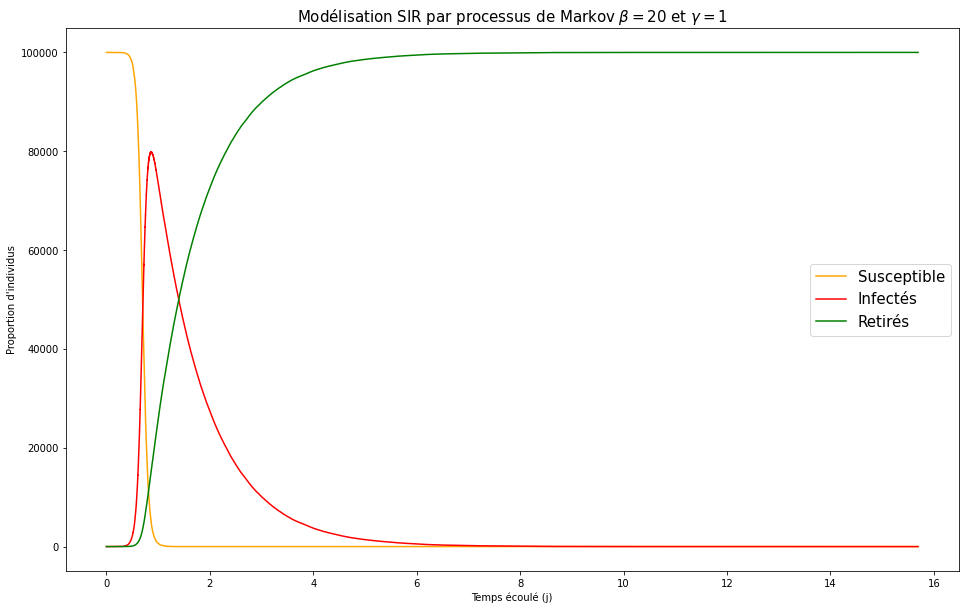

In [42]:
afficher_markov(processus_markov(20, 1))

Pour qu'il y ait une partie de la population retirée et une partie qui reste susceptible if faut que $R_0 \geq 1$, en pratique il faut également qu'il soit suffisamment élevé pour limiter les possibilités que l'infecté initial soit retiré avant de propager la maladie. 

On voit sur le graphique suivant que $\beta = 3.5$ et $\gamma = 1$ convient. 

Susceptibles restant : 3427
Infectés restant : 0
Retirés : 96573


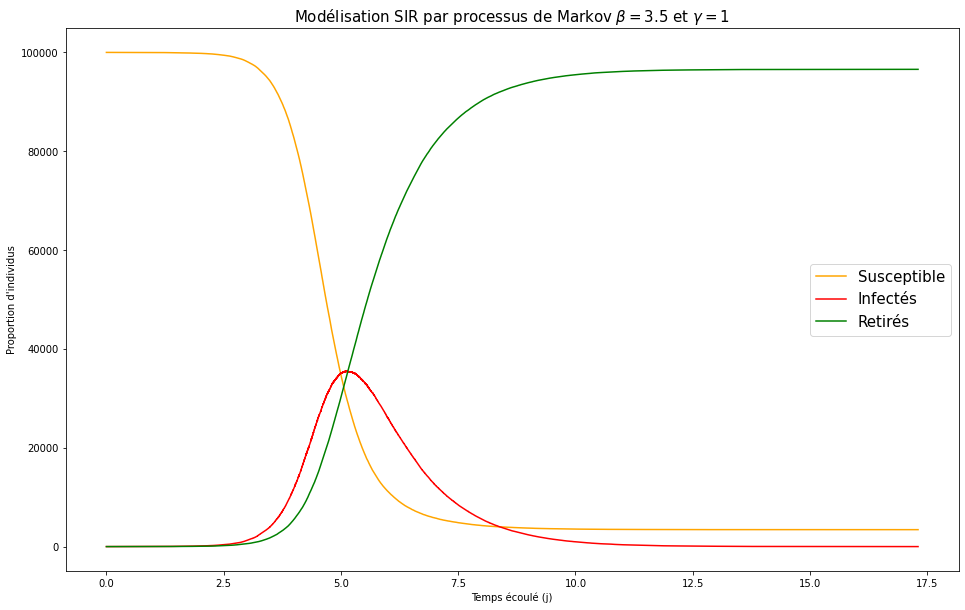

In [43]:
afficher_markov(processus_markov(3.5, 1))

## Comparaison des deux modèles et limites

In [44]:
N_tab = [100000, 1000000, 2000000]

In [45]:
def comparaison(beta, gamma, N_array):
    fig, ax = plt.subplots(len(N_array), 1, figsize=(25, 15))
    for i, el in enumerate(N_array):
        St, It, Rt, T, beta, gamma = processus_markov(beta, gamma, N=el)
        St = np.array(St) / el
        It = np.array(It) / el
        Rt = np.array(Rt) / el
        results, t, beta, gamma = epidemio_deterministe(beta, gamma, N=el)
        S = results[:, 0]
        I = results[:, 1]
        R = results[:, 2]
        ax[i].plot(t, S, color=(0.8, 0.2, 0), label='Susceptible deterministe')
        ax[i].plot(T, St, color=(0.8, 0.2, 0, 0.5), linestyle='-.', label='Susceptible Markov')
        ax[i].plot(t, I, color=(0.1, 0.8, 0.1), label='Infectés deterministe')
        ax[i].plot(T, It, color=(0.1, 0.8, 0.1, 0.5), linestyle='-.', label='Infectés Markov')
        ax[i].plot(t, R, color=(0, 0.2, 0.9), label='Retirés deterministe')
        ax[i].plot(T, Rt, color=(0, 0.2, 1, 0.9), linestyle='-.', label='Retirés Markov')
    plt.legend()
    plt.show()
        
    

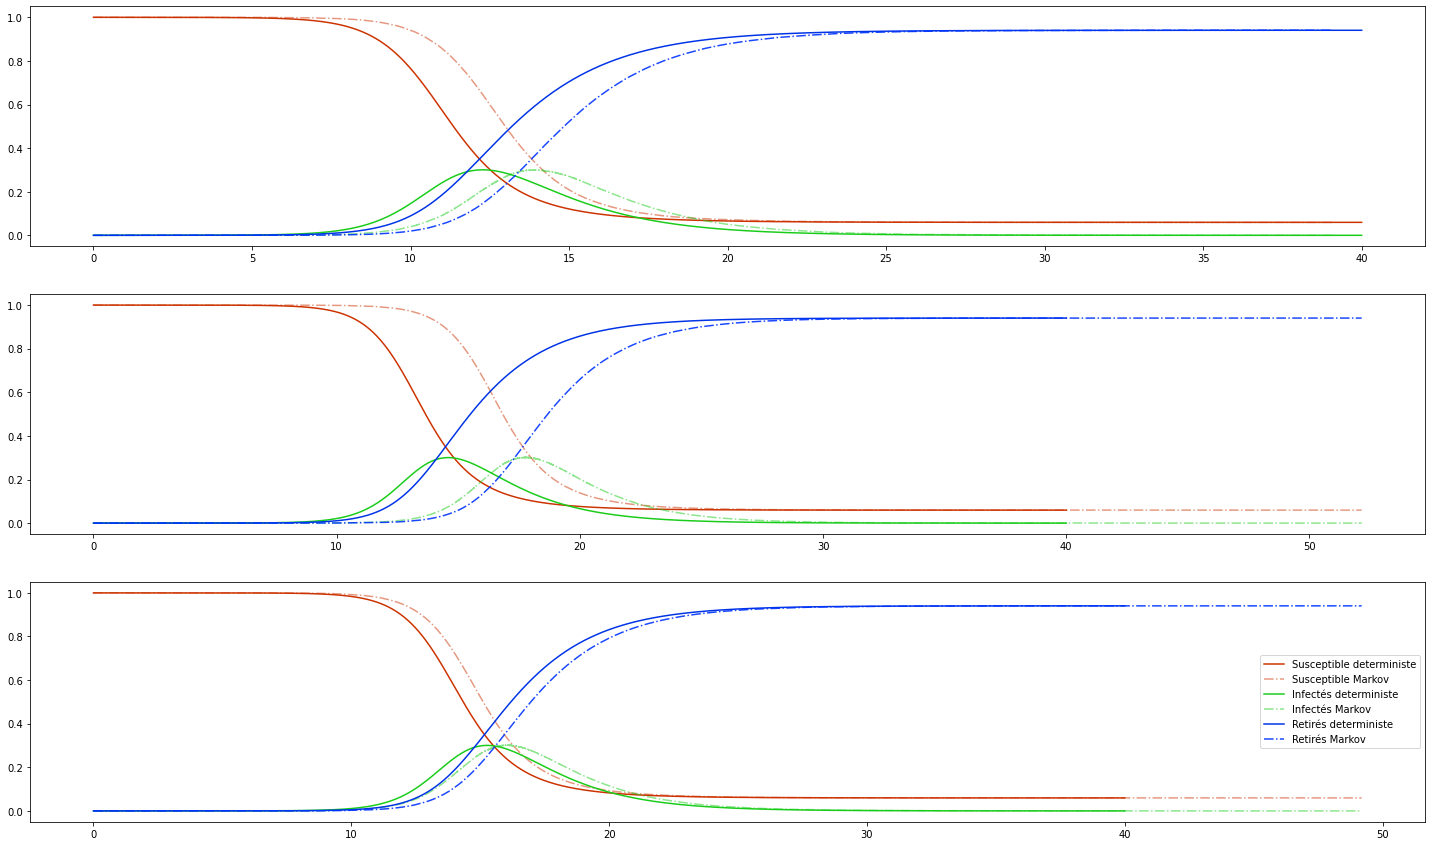

In [46]:
comparaison(1.5, 0.5, N_tab)

### Question ouverte

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [48]:
#donnees-hospitalieres-nouveaux-covid19 devient covid_hospit_incid
df = pd.read_excel("/content/covid-hospit-incid-2022-06-24-20h23.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: '/content/covid-hospit-incid-2022-06-24-20h23.xlsx'

In [ ]:
#example avec Paris car beaucoup de cas
paris = df[df["dep"]==75]

Text(0.5, 1.0, 'Visualisation des données covid-hospit-incid')

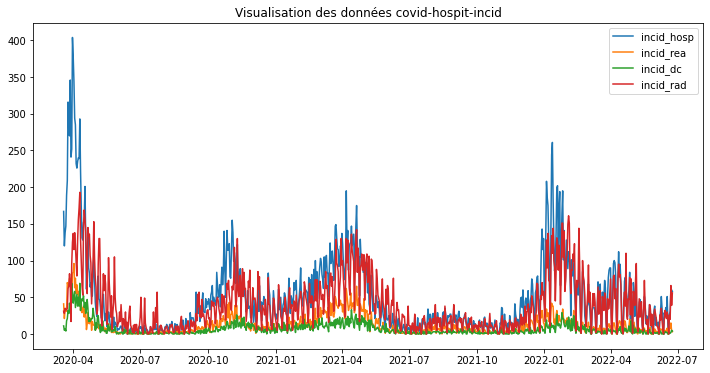

In [ ]:
plt.figure(figsize=(12,6)) 
plt.plot(paris["jour"],paris["incid_hosp"], label="incid_hosp")
plt.plot(paris["jour"],paris["incid_rea"], label="incid_rea")
plt.plot(paris["jour"],paris["incid_dc"], label="incid_dc")
plt.plot(paris["jour"],paris["incid_rad"], label="incid_rad")
plt.legend()
plt.title("Visualisation des données covid-hospit-incid")

Text(0.5, 1.0, 'Visualisation des individus infectieux')

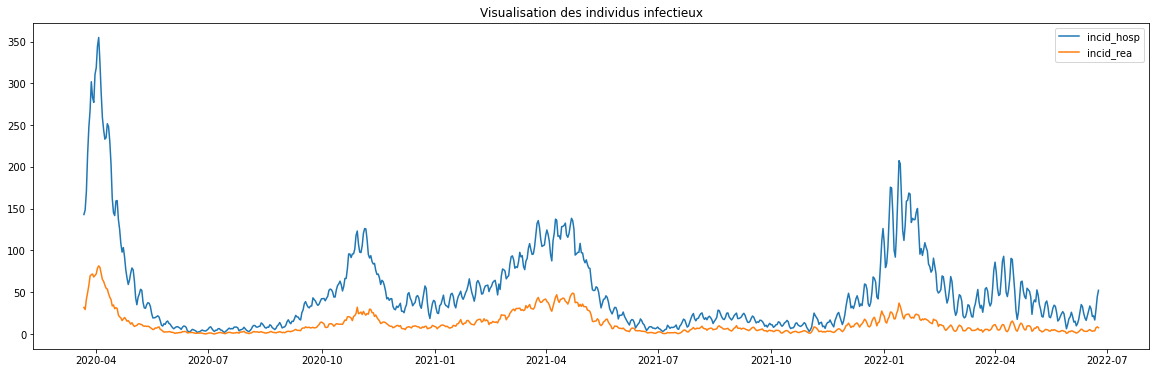

In [ ]:
plt.figure(figsize=(20,6)) 
#moyenne glissante sur 7 jours afin de lisser la courbe
plt.plot(paris["jour"],paris["incid_hosp"].rolling(4).mean(), label="incid_hosp")
plt.plot(paris["jour"],paris["incid_rea"].rolling(4).mean(), label="incid_rea")
plt.legend()
plt.title("Visualisation des individus infectieux")

Nous pouvons observer que le nombre de personnes hospitalisées augmente simultanément avec le nombre de personnes en réanimation et inversement, nous pouvons donc faire la somme de ces données pour en déduire le nombre d'individus infectieux.

Text(0.5, 1.0, 'Visualisation des individus retirés')

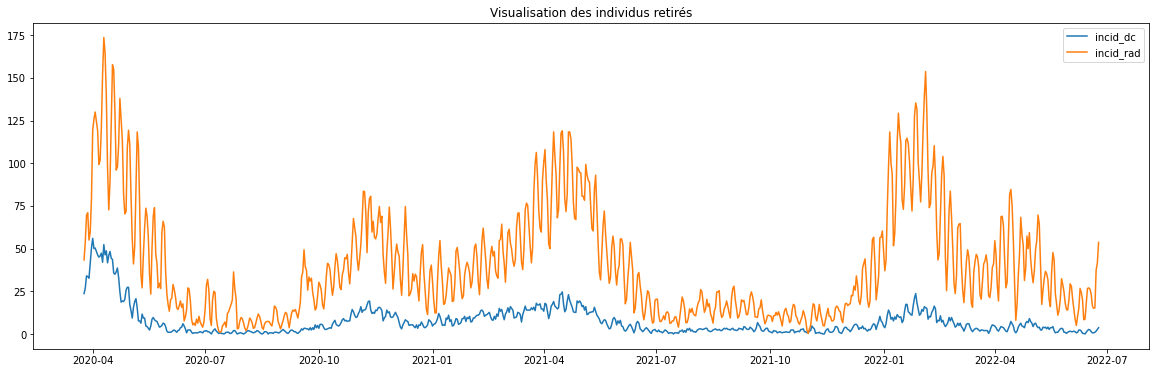

In [ ]:
plt.figure(figsize=(20,6)) 
#moyenne glissante sur 7 jours afin de lisser la courbe
plt.plot(paris["jour"],paris["incid_dc"].rolling(3).mean(), label="incid_dc")
plt.plot(paris["jour"],paris["incid_rad"].rolling(3).mean(), label="incid_rad")
plt.legend()
plt.title("Visualisation des individus retirés")

De la même manière, nous pouvons observer que le nombre de personnes décédéss augmente simultanément avec le nombre de personnes qui sont sorties de l'hôpital et inversement, nous pouvons donc faire la somme de ces données pour en déduire le nombre d'individus retirés.

In [ ]:
paris.loc[:,"infectieux"] = paris.loc[:,"incid_hosp"].rolling(3).mean() + paris.loc[:,"incid_rea"].rolling(3).mean()
paris.loc[:,"retirés"] = paris.loc[:,"incid_dc"].rolling(3).mean() + paris.loc[:,"incid_rad"].rolling(3).mean()
paris = paris[3:]
paris

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad,infectieux,retirés
62110,75,2020-03-29,241,69,25,17,359.333333,87.666667
62111,75,2020-03-30,252,52,69,96,345.333333,101.333333
62112,75,2020-03-31,404,83,57,125,367.000000,129.666667
62113,75,2020-04-01,378,84,42,137,417.666667,175.333333
62114,75,2020-04-02,344,96,51,115,463.000000,175.666667
...,...,...,...,...,...,...,...,...
62923,75,2022-06-20,27,7,2,26,14.333333,15.666667
62924,75,2022-06-21,31,8,1,20,24.333333,16.333333
62925,75,2022-06-22,60,15,2,66,49.333333,39.000000
62926,75,2022-06-23,60,4,5,39,59.333333,44.333333


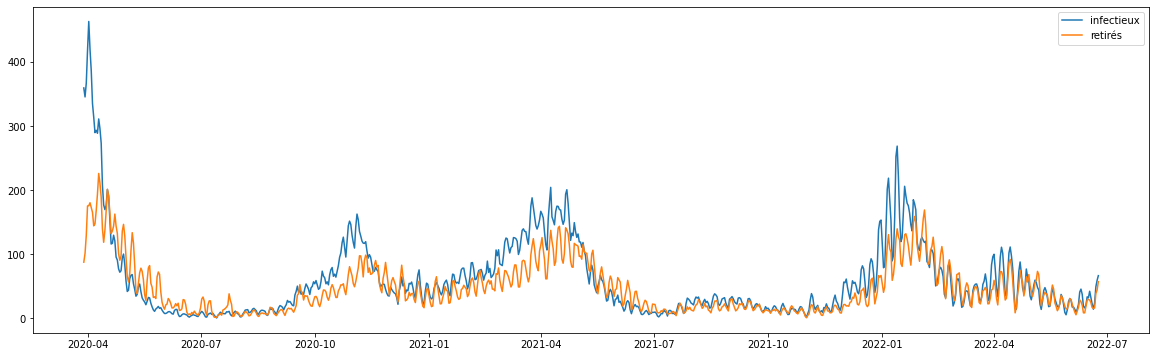

In [ ]:
plt.figure(figsize=(20,6)) 
plt.plot(paris["jour"],paris["infectieux"], label="infectieux")
plt.plot(paris["jour"],paris["retirés"], label="retirés")
plt.legend()

On observe un léger décalage entre les pics d'infectieux et ceux des retirés que nous allons utiliser pour estimer le temps de "guérison" qui nous permettra d'en déduire le taux de "guérison" et donc $\gamma$. 

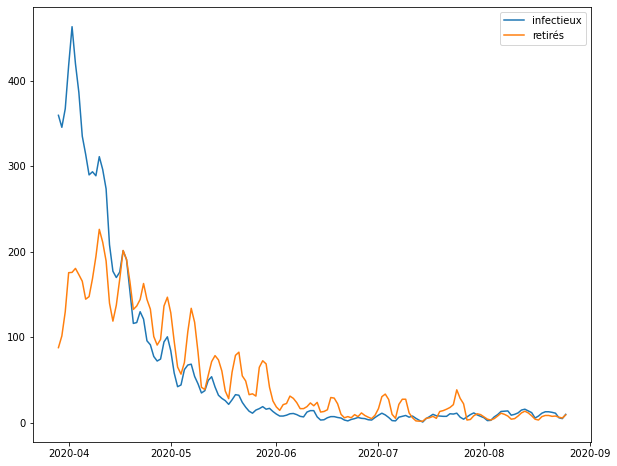

In [ ]:
#première vague
plt.figure(figsize=(10,8)) 
new = paris[:150]
plt.plot(new["jour"],new["infectieux"], label="infectieux")
plt.plot(new["jour"],new["retirés"], label="retirés")
plt.legend()

In [ ]:
new

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad,infectieux,retirés
62110,75,2020-03-29,241,69,25,17,359.333333,87.666667
62111,75,2020-03-30,252,52,69,96,345.333333,101.333333
62112,75,2020-03-31,404,83,57,125,367.000000,129.666667
62113,75,2020-04-01,378,84,42,137,417.666667,175.333333
62114,75,2020-04-02,344,96,51,115,463.000000,175.666667
...,...,...,...,...,...,...,...,...
62255,75,2020-08-21,10,4,0,11,12.000000,7.333333
62256,75,2020-08-22,3,0,2,5,11.000000,7.666667
62257,75,2020-08-23,0,0,0,1,5.666667,6.333333
62258,75,2020-08-24,8,3,0,8,4.666667,5.333333


In [ ]:
#première vague
index_inf = np.where(new["infectieux"] == np.max(new["infectieux"]))[0][0]
index_ret = np.where(new["retirés"] == np.max(new["retirés"]))[0][0]
date_inf = paris.loc[62110+index_inf,"jour"]
date_ret = paris.loc[62110+index_ret,"jour"]
print("jour_infectieux : ",date_inf)
print("jour_retirés : ",date_ret)
ecart1 = date_ret - date_inf
print("l'écart de jours est : ",ecart1)

jour_infectieux :  2020-04-02 00:00:00
jour_retirés :  2020-04-10 00:00:00
l'écart de jours est :  8 days 00:00:00


R_inf vaut :  8152.333333333329


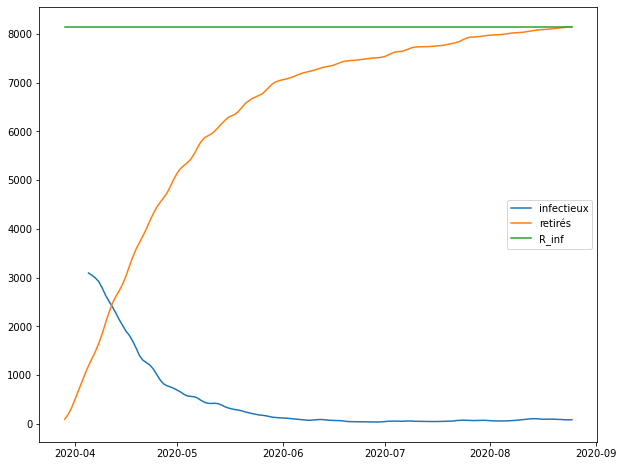

In [ ]:
#première vague
plt.figure(figsize=(10,8)) 
plt.plot(new["jour"],new["infectieux"].rolling(8).sum(), label="infectieux")
plt.plot(new["jour"],new["retirés"].cumsum(axis = 0), label="retirés")
r_inf = np.max(new["retirés"].cumsum(axis = 0))
print("R_inf vaut : ",r_inf)
plt.plot(new["jour"],np.array([r_inf for x in new["jour"]]), label="R_inf")
plt.legend()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


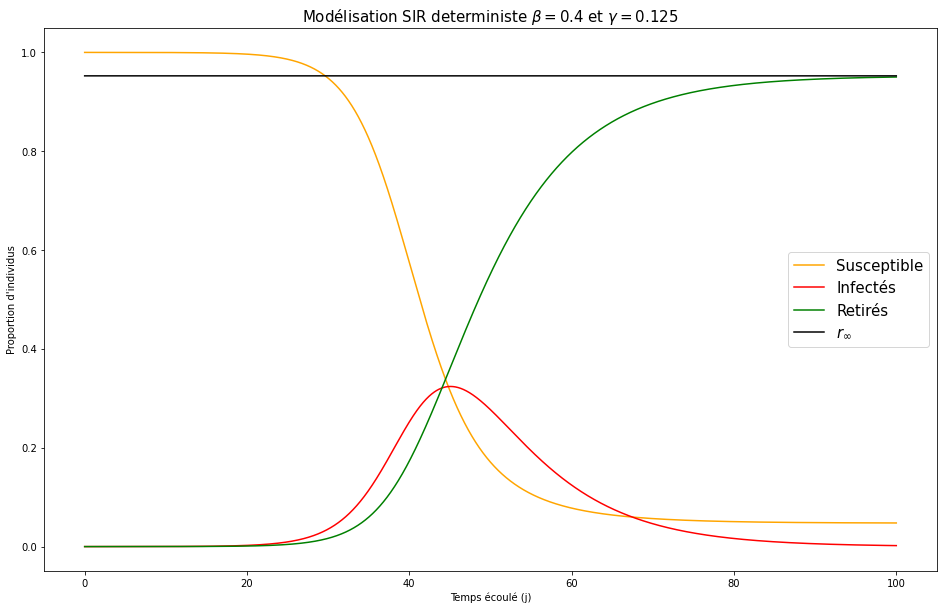

In [ ]:
afficher_resultats(epidemio_deterministe(0.4, 0.125, duree=100) )

Dans le cas de la première vague, on en déduit des paramètres $\gamma = \frac{1}{8}$ et  $\beta = \frac{4}{10}$ qui semblent correspondre à notre modélisation. $\gamma$ est estimé avec $\gamma = \frac{1}{T_{g}}$ où ${T_{g}}$ est le temps de moyen de guérison et $\beta$ est estimé grâce au modèle mathématique en essayant de trouver une courbe qui se rapproche de la notre. On obtient un $R_0=3.2$ qui est cohérent avec les informations que l'on trouve sur Internet. 

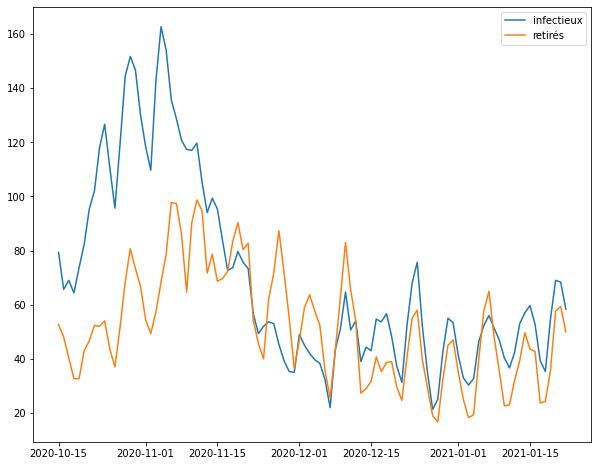

In [ ]:
#deuxième vague
plt.figure(figsize=(10,8)) 
new = paris[200:300]
plt.plot(new["jour"],new["infectieux"], label="infectieux")
plt.plot(new["jour"],new["retirés"], label="retirés")
plt.legend()

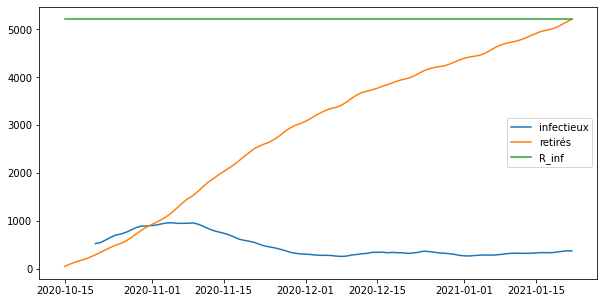

In [ ]:
#deuxième vague
plt.figure(figsize=(10,5)) 
plt.plot(new["jour"],new["infectieux"].rolling(7).sum(), label="infectieux")
plt.plot(new["jour"],new["retirés"].cumsum(axis = 0), label="retirés")
r_inf = np.max(new["retirés"].cumsum(axis = 0))
plt.plot(new["jour"],np.array([r_inf for x in new["jour"]]), label="R_inf")
plt.legend()

In [ ]:
#deuxième vague
index_inf = np.where(new["infectieux"] == np.max(new["infectieux"]))[0][0]
index_ret = np.where(new["retirés"] == np.max(new["retirés"]))[0][0]
date_inf = paris.loc[62107+index_inf,"jour"]
date_ret = paris.loc[62107+index_ret,"jour"]
print("jour_infectieux : ",date_inf)
print("jour_retirés : ",date_ret)
ecart2 = date_ret - date_inf
print("l'écart de jours est : ",ecart2)

jour_infectieux :  2020-04-15 00:00:00
jour_retirés :  2020-04-22 00:00:00
l'écart de jours est :  7 days 00:00:00


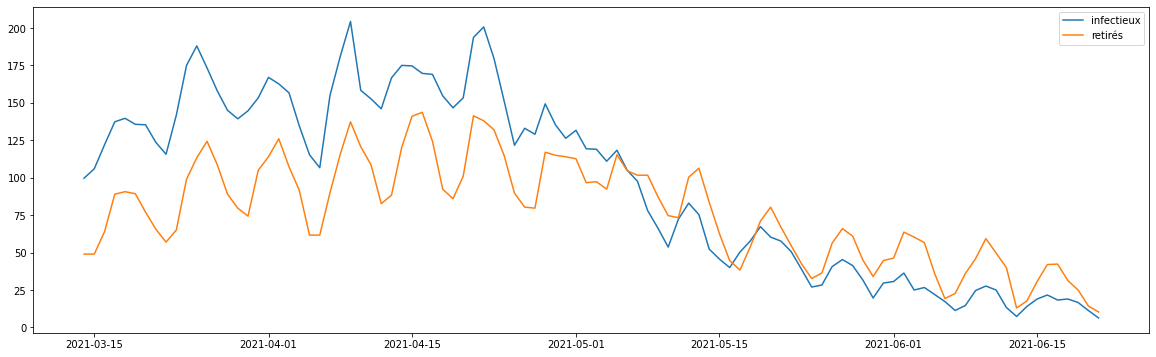

In [ ]:
#troisième vague
plt.figure(figsize=(20,6)) 
new = paris[350:450]
plt.plot(new["jour"],new["infectieux"], label="infectieux")
plt.plot(new["jour"],new["retirés"], label="retirés")
plt.legend()

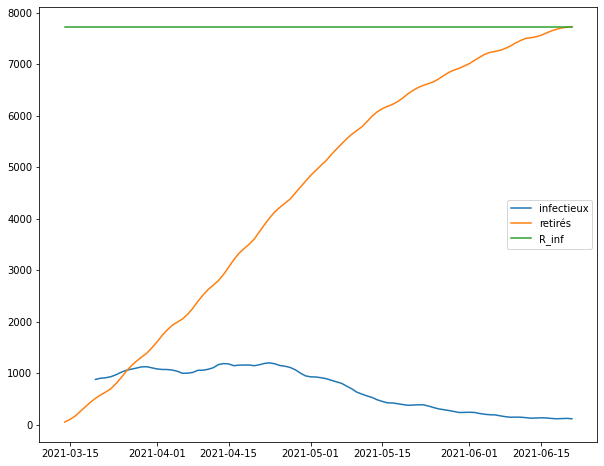

In [ ]:
#troisième vague
plt.figure(figsize=(10,8)) 
plt.plot(new["jour"],new["infectieux"].rolling(7).sum(), label="infectieux")
plt.plot(new["jour"],new["retirés"].cumsum(axis = 0), label="retirés")
r_inf = np.max(new["retirés"].cumsum(axis = 0))
plt.plot(new["jour"],np.array([r_inf for x in new["jour"]]), label="R_inf")
plt.legend()

In [ ]:
#troisième vague
index_inf = np.where(new["infectieux"] == np.max(new["infectieux"]))[0][0]
index_ret = np.where(new["retirés"] == np.max(new["retirés"]))[0][0]
date_inf = paris.loc[62107+index_inf,"jour"]
date_ret = paris.loc[62107+index_ret,"jour"]
print("jour_infectieux : ",date_inf)
print("jour_retirés : ",date_ret)
ecart3 = date_ret - date_inf
print("l'écart de jours est : ",ecart3)

jour_infectieux :  2020-04-21 00:00:00
jour_retirés :  2020-04-28 00:00:00
l'écart de jours est :  7 days 00:00:00


Pour les vagues suivantes, on  trouve un $\gamma = \frac{1}{7}$. Cependant, les résultats pour celles-ci semblent moins en accord avec notre modèle mathématique donc il est difficile de trouver des paramètres adéquats. Cela peut peut-être s'expliquer par le fait que le modèle n'est pas adapté aux nouvelles mesures prises (confinement, gestes barrières...).